[2025_12_12]_보스턴 집 가격 예측
- 필수
   * 교차검증
   * 데이터 누수 안됨!
   * 모델 : 회귀 모델,  배깅 앙상블-랜덤포레스트
- 기한 : 주말(12월 14일 일요일까지)

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
## ==========================================
## [1-1] 모듈 로딩
## ==========================================
import pandas as pd
import numpy as np

## 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 관련
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

## ML 모델 성능지표 관련 모류
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error, r2_score

## Cow 활성화 : 복사와 공유 자동 설정 기능 활성화
pd.options.mode.copy_on_write = True

# 판다스/넘파이에 지수표기법(과학적표기법) 정지 설정
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=6, suppress=True)



In [2]:
## =======================================
## [1-2] 데이터 준비 및 확인
## =======================================
## 데이터 준비
columns = [
    'CRIM','ZN','INDUS','CHAS','NOX','RM','AGE',
    'DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'
]

## 공백(하나이상)으로 나누기
df = pd.read_csv('../Data/housing.csv', sep=r'\s+', names=columns)

df.info()

df.to_csv('temp.csv')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [3]:
## ========================================================
## 상관 관계 시각화 => Linear Model로써
##                  피쳐와 타겟 선형 관계성
## ========================================================
## => 상관계수 계산 : [기] person => 피쳐와 타겟의 직선의 선형성
corr_ = df.corr(numeric_only=True)
display(corr_)

print(corr_.MEDV.sort_values(ascending=False))


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00000,-0.20047,0.40658,-0.05589,0.42097,-0.21925,0.35273,-0.37967,0.62551,0.58276,0.28995,-0.38506,0.45562,-0.38830
ZN,-0.20047,1.00000,-0.53383,-0.04270,-0.51660,0.31199,-0.56954,0.66441,-0.31195,-0.31456,-0.39168,0.17552,-0.41299,0.36045
INDUS,0.40658,-0.53383,1.00000,0.06294,0.76365,-0.39168,0.64478,-0.70803,0.59513,0.72076,0.38325,-0.35698,0.60380,-0.48373
CHAS,-0.05589,-0.04270,0.06294,1.00000,0.09120,0.09125,0.08652,-0.09918,-0.00737,-0.03559,-0.12152,0.04879,-0.05393,0.17526
NOX,0.42097,-0.51660,0.76365,0.09120,1.00000,-0.30219,0.73147,-0.76923,0.61144,0.66802,0.18893,-0.38005,0.59088,-0.42732
RM,-0.21925,0.31199,-0.39168,0.09125,-0.30219,1.00000,-0.24026,0.20525,-0.20985,-0.29205,-0.35550,0.12807,-0.61381,0.69536
AGE,0.35273,-0.56954,0.64478,0.08652,0.73147,-0.24026,1.00000,-0.74788,0.45602,0.50646,0.26152,-0.27353,0.60234,-0.37695
DIS,-0.37967,0.66441,-0.70803,-0.09918,-0.76923,0.20525,-0.74788,1.00000,-0.49459,-0.53443,-0.23247,0.29151,-0.49700,0.24993
RAD,0.62551,-0.31195,0.59513,-0.00737,0.61144,-0.20985,0.45602,-0.49459,1.00000,0.91023,0.46474,-0.44441,0.48868,-0.38163
TAX,0.58276,-0.31456,0.72076,-0.03559,0.66802,-0.29205,0.50646,-0.53443,0.91023,1.00000,0.46085,-0.44181,0.54399,-0.46854


MEDV       1.00000
RM         0.69536
ZN         0.36045
B          0.33346
DIS        0.24993
CHAS       0.17526
AGE       -0.37695
RAD       -0.38163
CRIM      -0.38830
NOX       -0.42732
TAX       -0.46854
INDUS     -0.48373
PTRATIO   -0.50779
LSTAT     -0.73766
Name: MEDV, dtype: float64


In [4]:
## 피쳐 타겟 분리
targetSR = df['MEDV']
featureDF = df.drop('MEDV',axis=1)

x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size=0.2,
                                                    random_state=10,
                                                    # stratify=targetSR ## 분류에만 사용, 회귀는 X
                                                    )

print(f'[TRAIN] x_train:{x_train.shape},  y_train:{y_train.shape}')
print(f'[TEST] x_test:{x_test.shape},  y_test:{y_test.shape}')

[TRAIN] x_train:(404, 13),  y_train:(404,)
[TEST] x_test:(102, 13),  y_test:(102,)


[3] 학습 진행 <hr>

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler


pipe_rf = Pipeline([
    ("scaler", RobustScaler()),              # 수치형 스케일링
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

In [9]:

param_grid = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE 기준
    n_jobs=-1,
    verbose=1
)

In [10]:
grid.fit(x_train, y_train)

print("Best CV RMSE:", -grid.best_score_)
print("Best Params:", grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best CV RMSE: 3.418919268942056
Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}


In [11]:
best_model = grid.best_estimator_

pred = best_model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print("\n[TEST 성능]")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)



[TEST 성능]
RMSE: 3.965049286893485
MAE : 2.7434248366013034
R²  : 0.8496700692786262


,feature,importance
12,LSTAT,0.49219
5,RM,0.33073
7,DIS,0.05657
0,CRIM,0.03218
4,NOX,0.02225
11,B,0.01595
10,PTRATIO,0.01364
6,AGE,0.01360
9,TAX,0.01171
2,INDUS,0.00508


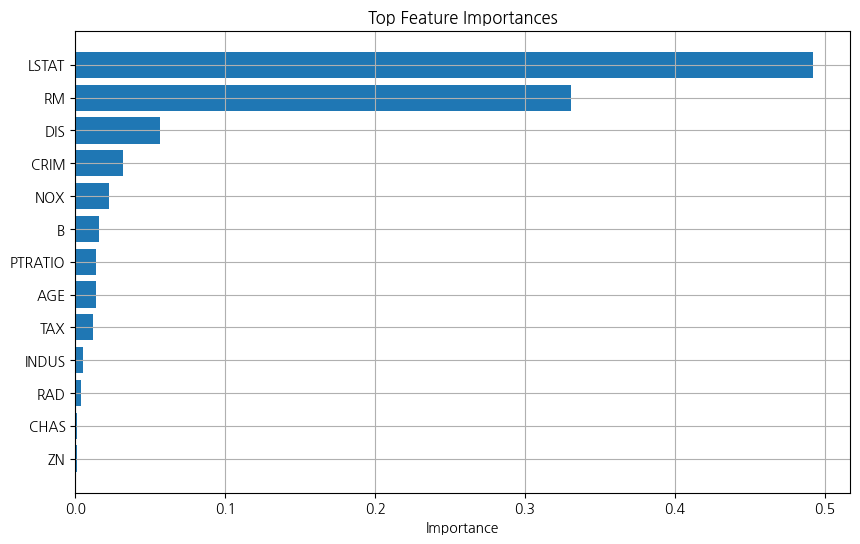

In [12]:
importances = best_model.named_steps["model"].feature_importances_

fi = pd.DataFrame({
    "feature": featureDF.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

display(fi.head(10))

# 시각화
top = fi.head(15)[::-1]
plt.figure(figsize=(10,6))
plt.barh(top["feature"], top["importance"])
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.grid(True)
plt.show()
